# Implied Volatility

The implied volatility is a measure of market risk and helps to determine changes in the supply and demand of a security; however, the implied volatility does not provide the direction of the change. The implied volatility can be calculated from option prices using the Black-Scholes formula. This metric gives a forward-looking perspective to the analyst. When the market is bearish, the volatility tends to increase; on the other hand, when investors expect prices to rise, the implied volatility tends to fall.

This notebook will provide an algorithm to calculate the implied volatility for a given security using the call option chain of a security. The algorithm first retrives the variables needed to calculate the call price with the Black-Scholes model assuming there is no dividend payment. Then, the algorithm estimates the spread between the calculated call price and the actual market price. Finaly, the algorithm finds the implied volatility that makes the square differences closest to zero.

Importing all necessary libraries first.

In [1]:
import yfinance as yf
from datetime import datetime
import quandl
import stockquotes
import numpy as np
import scipy.stats as st 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import os

%matplotlib inline

This notebook analyses the implied volatility using the SPDR S&P500 ETF as a proxy of the market. The volatility is forward-looking to one month ahead. 

In [2]:
#Defining the security ticker to analyze, the expiration date of the option, and risk free time to maturity
ticker = 'SPY'
expiration = '2021-02-04'
ttm = '1 MO'

In [3]:
#Dictionaries to customize the font of labels and titles of graphs
label_dict = {'fontsize': 14,
            'fontweight' : 5,
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'
             }
title_dict = {'fontsize': 20,
           'fontweight' : 5,
           'verticalalignment': 'baseline',
           'horizontalalignment': 'center'
             }

### Option pricing

An option is a financial instrument that derives its value from an underlying asset. There are two types of option, calls and puts. A call option gives the holder the right to buy the underlying asset at a predetermined price, called strike price, on the expiration date of the call. A put option gives the holder the right to sell the underlying asset at the strike price on the expiration date.

In a call option, if the strike price is less than the spot price, the buyer of the option will have a positive return. Whereas, on a put option, the long side will benefit if the strike price is higher than the spot price. An option is in-the-money if the option provides a positive value, the option is out-of-the-money when it doesn't have intrinsic value; meaning that if the option is exercised, there is not going to be a profit. An option is at-the-money when the strike price is equal to the spot price of the underlying asset.

The price of the option is the premium that the long position must pay to bear the opportunity to buy or sell the underlying asset. The formula to calculate the call price for an European option that does not pay dividends is given by:

\begin{equation*}
C = S_t N \left(d1 \right) - K e^{-rt} N \left(d2 \right)
\end{equation*}

__Where:__

\begin{equation*}
d1 = \frac{ \ln{ \frac{S_t}{K} + \left(r + \frac{\sigma_u^2}{2} \right) t} }{\sigma_s \sqrt{t}}
\end{equation*}

and:

\begin{equation*}
d2 = d1 -  \sigma_s \sqrt{t}
\end{equation*}

__Where:__

\begin{alignat*}{1}
&C \quad & = \quad & \text{Call option price} \\
&S \quad & = \quad & \text{Current stock (or other underlying) price} \\
&K \quad & = \quad & \text{Strike price} \\
&r \quad & = \quad & \text{Risk-free interest rate} \\
&t \quad & = \quad & \text{time to maturity} \\
&\sigma \quad & = \quad & \text{Implied volatility} \\
&N \quad & = \quad & \text{A normal distribution}
\end{alignat*}

The target variable in the formula is sigma or the implied volatility.  

Before coding the algorithm to calculate the implied volatility, there are some helpful functions that must be defined. The first function is <code>Spot()</code> that retrives the current stock price given the ticker symbol. This function uses the module <code>stockquotes</code> that collects stock price data from Yahoo Finance.

In [4]:
def Spot(ticker):
    '''
    Takes a ticker symbol and returns the last price of the asset.
    
    Arguments:
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to find 
              the symbol
              
    Returns:
    S -- Spot price of the asset
    '''
    
    security = stockquotes.Stock(ticker)
    S = security.current_price

    return S    

The SPDR S&P500 distributes dividends quarterly, the next distribution is expected to be until March 2021. This is in line with the assumption in the Black-Scholes formula of no dividend payments. 

Retriving the spot price of the SPDR S&P500 using the function define above:

In [5]:
S = Spot(ticker)
print(f'The last price of the SPDR S&P500 was ${S}, thus preferred strike prices are in the range of',end=" ") 
print(f'${round(S-30)} - ${round(S+30)}')

The last price of the SPDR S&P500 was $372.03, thus preferred strike prices are in the range of $342 - $402


The next step would be to retrieve the strike price and the call premiun. The <code>call_data()</code> function gets these two pieces of information using the <code>yfinance</code> library. The function requires to specify the ticker symbol and the expiration date; then it returns a tuple with the strike price and call premium available for the expiration selected. 

The timeframe of the implied volatility analysis determines the most appropriate expiration date; for example, an analyst interested to investigate the forward-looking volatility in one year, should use options with an expiration of one year from now. In this notebook, the expiration of the option is on Feb 04, 2021; thus, the implied volatility is of approximate one month from now.

In [6]:
def call_data(ticker,expiration):
    '''
    Extracts the strike price and call premium of an option given the ticker symbol of the underlying asset and 
    the expiration date. Returns a list of strike price and call premium.
    
    Arguments:
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to find 
              the symbol
              
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset
                  
    Returns:
    data -- list containig pairs of strike price and call premiums available for the underlying in the expiration 
            selected
    '''
    
    security = yf.Ticker(ticker)
    
    if expiration not in security.options:                       #Assertion to verify that expiration exists
        print('Option expiration not available, please verify')
        return
        
    options = security.option_chain(expiration)
    calls = options.calls
    strike_price = calls['strike']
    call_premium = calls['lastPrice']
    
    data = list(zip(strike_price, call_premium))
    data = np.array(data)

    
    return data

In [7]:
data = call_data(ticker,expiration)
print(f'For expiration on {expiration} there are {len(data)} strike price available','\n')
print(f'The call with strike price of ${data[0][0]} has a call premium of ${data[0][1]}')
print(f'The call with strike price of ${data[2][0]} has a call premium of ${data[2][1]}')
print(f'The call with strike price of ${data[10][0]} has a call premium of ${data[10][1]}')
print(f'The call with strike price of ${data[20][0]} has a call premium of ${data[20][1]}')


For expiration on 2021-02-04 there are 24 strike price available 

The call with strike price of $342.5 has a call premium of $32.37
The call with strike price of $352.5 has a call premium of $23.98
The call with strike price of $382.5 has a call premium of $3.39
The call with strike price of $410.0 has a call premium of $0.22


Plotting the call premium against each strike price:

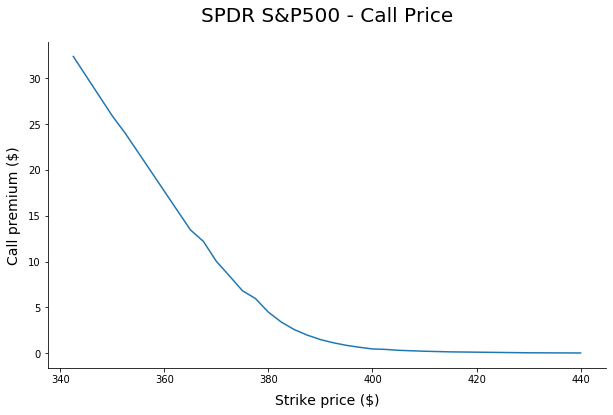

In [8]:
K, call_premium = list(zip(*data)) #unpacking the results of call_data function
K = np.array(K)
call_premium = np.array(call_premium)

# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(K.tolist(), call_premium)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.title('SPDR S&P500 - Call Price', fontdict=title_dict, pad=20)
plt.xlabel('Strike price ($)',fontdict=label_dict,labelpad=20)
plt.ylabel('Call premium ($)',fontdict=label_dict, labelpad=10)

plt.show()


As noticed in the graph, the greater the strike price, the lower the call premium that the investor has to pay which is in line with the relationship stablished in the Black-Scholes formula from above.

The next variable to deteremine is the risk free rate. This is the return on a treasury bond that matches the timeframe of the implied volatility. In this example, the expiration of the option chain is one month therefore the most accurate representation of the risk free rate is a 1 month US Treasury bill. 

The function <code>Risk_free</code> takes a predefined time to maturity and using <code>Quandl</code> module calls the table with historic yield curve; then, selects the latest rate that matches the specified maturity. 

__Note:__ to access Quandl API, the reader should use a personal API Key. This key can be obtained when signing up an account at Quandl website. 

In [9]:
def Risk_free(ttm):
    '''
    Extracts the most recent US treasury rate given the time to maturity.
    
    Arguments:
    ttm -- Time to maturity in string format. The available options are:
           ['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']
    
    Returns:
    rf -- Most recent risk free rate for the time to maturity selected
    '''
    API_KEY = os.environ.get('QUANDL_KEY')
    yield_curve = quandl.get('USTREASURY/YIELD', authtoken=API_KEY)
    rf = yield_curve[ttm][-1]/100
    
    return rf    

In [10]:
r = Risk_free(ttm)

print(f'The risk free rate for {ttm} to maturity is {r*100}%')

The risk free rate for 1 MO to maturity is 0.06%


The last element needed to complet the formula is the time to maturity. This is the difference, measured in years, between the expiration of the option and the current date. The function <code>Time_to_maturity</code> will make this calculation.

In [11]:
def Time_to_maturity(expiration):
    '''
    Calculates the time to maturity in years from today to the option expiration.
    
    Arguments:
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset 
                  
    Returns:
    ttm -- Time to maturity in year in float format
    '''
    
    today = datetime.now()
    expiration_d = datetime.strptime(expiration,'%Y-%m-%d')
    datetime_delta = (expiration_d - today).days
    ttm = datetime_delta/365
    
    return ttm
    

In [12]:
T = Time_to_maturity(expiration)

print(f'As of {str(datetime.now())[:10]}, the option chain with an expiration on {expiration}',end=" ")
print(f'will have a time to maturity of {round(T,4)} year')

As of 2020-12-30, the option chain with an expiration on 2021-02-04 will have a time to maturity of 0.0959 year


### Calculating the Implied Volatility

Now, it is time to build the algorithm that will estimate the implied volatility for an option chain given the expiration date. 

The first step is to retrive the variables needed in the Black-Scholes formula to calculate the call price. The <code>implied_vol</code> will call the previous defined functions for this step. This variables are:

- __Spot price:__ Scalar number with the latest price of the underlying value. 
- __Strike price:__ Numpy array of shape (n,) where n is the number of strike price available in the option chain
- __Call premium:__ Numpy array of shape (n,) 
- __Risk premium:__ Scalar number with the T-bill that is most representative given the time to maturity
- __Time to maturity:__ Scalar number representing the time from today to the expiration date measured in years

The goal is to calculate, for each strike price, the implied volatility that makes the difference between the calculated call premium and the actual market premium closest to zero. Note that to optimize the computational cost, the algorithm uses linear algebra when using the Black-Scholes formulas.

Based on this, the next step is to generate an array of potential implied volatilites. This array is randomly generated following a normal distribution and will have a shape of *j* elements where *j* is the number of iterations the algorithm will execute.

For each *j* element, there is going to be a call premium calculated based on the Black-Scholes formula. Then, the function calculates the square difference between the calculated call price and the observed market premium. At the end of the $j^{th}$ iteration, the algorithm selects the smallest difference with its corresponding implied volatility and calculated call price. These are saved as the optimum values for the given strike price.

Finally, this process is repeated for each strike price to obtain an array of implied volatilities for each strike price and the parameters from the Black-Scholes model are saved in cache.

The logic behind this algorithm is that with a high number of random sampling, the optimum implied volatility can be calculated with high accuracy. It is important to metion that the greater the sample, the higher the computational cost; thus there is a trade off between accuracy and computational cost. For the following expample, with 100,000 iterations, the algorithm took about 20 minutes to come up with 24 implied volatilities. 

In [13]:
def implied_vol(ticker, expiration, ttm, iterations = 25000):
    
    '''
    Optimization function that estimates the implied volatility of an option chain. 
    
    Arguments:                  
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to 
              find the symbol
              
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset  
                  
    ttm -- Time to maturity in string format. The available options are:
           ['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']
           
    iterations -- Number of times the algorithm has to run. The greater the number of iterations, the more accurate
                  result. Note that there is a trade off between computational cost and accuracy. recommended at least 
                  25,000 iterations. It might take a couple of minutes.
                  
    Returns:
    imply_vol -- Implied volatility that makes the difference between the market call price and the call price 
                 calculated using the Black-Scholes Model closest to zero. Numpy array of shape equal to number of 
                 strike price available for the option.
                 
    difference -- The closest to zero spread between the market call price and the call price calculated using the 
                  Black-Scholes Model. Numpy array of shape equal to number of strike price available for the option.
                  
    cache -- cache of values needed to calculate the call price with the Black-Scholes formula
                  
    '''
    # Retriving the current spot price
    S = Spot(ticker)
    S = np.array(S)
    
    # Retriving the array of strike price and market call price
    data = call_data(ticker,expiration)
    K, call_premium = list(zip(*data)) #unpacking the results of call_data function
    K = np.array(K)
    call_premium = np.array(call_premium)
      
    # Retriving the closest risk-free rate corresponding to the maturity of the option
    r = Risk_free(ttm)
    
    # Calculating the time to maturity of the option
    T = Time_to_maturity(expiration)
    print('Data downloaded successfully')
    # Creating a sample of random numbers representing the implied volatility distribution
    # The sample follows a normal distribution
    sigma_ran = np.random.randn(iterations)
    
    # Empty lists that will contain the minimun difference and the corresponding implied volatility
    imply_vol = []
    difference = []
    C = []
    
    print('Starting to iterate')
    print('Please wait ...')
    # Loop through each strike price
    for n in range(0,len(K)):
        
        # Empty lists that will contain the positive spreads, the negative spreads, and their implied volatility
        spread_list = []
        sigma_list = []
        C_list = []
    
        # Loop through each value in the sample list of potential implied volatility
        for j in range(0,len(sigma_ran)):
            
            # Calculating the call price for each implied volatility given a specific strike price
            d1 = (np.log(np.divide(S,K[n]))+(r+((np.power(sigma_ran[j],2)/2))*T))/(sigma_ran[j]*np.sqrt(T))
            N_d1 = st.norm.cdf(d1)

            d2 = np.subtract(d1,sigma_ran[j]*np.sqrt(T))
            N_d2 = st.norm.cdf(d2)

            Call_premium_calc = np.subtract(np.multiply(S,N_d1),np.multiply(K[n],np.multiply(np.exp(-r*T),N_d2)))
            
            # Calculating the spread between the previous calculation and the market call price
            spread = np.subtract(Call_premium_calc, call_premium[n])
            
            # Squaring the spread to remove negative sign and saving the spread, sigma, and call price in a list
            spread_list.append(spread**2)
            sigma_list.append(sigma_ran[j])
            C_list.append(Call_premium_calc)

        # Finding the minimum spread and the index where it's located
        min_dif = np.min(spread_list)
        index_min_dif = np.argmin(spread_list)
        
        # Selecting the sigma and call price corresponding to the minimum spread found
        sigma_optimun = sigma_list[index_min_dif]
        spr = min_dif
        C_opt = C_list[index_min_dif]
    
        # Saving the implied volatility and call price that makes the spread the lowest
        C.append(C_opt)
        imply_vol.append(sigma_optimun)
        difference.append(spr)

    # Values required to calculate the call price using Black-Scholes formula
    print('Completed!')
    cache = (S,K,C,call_premium,r,T)
     
    return imply_vol, difference, cache

Calculating the implied volatilities for the SPDR S&P500 example used before. The algorithm saves in cache all variables used in the Black-Scholes model for each optimum implied volatility.

In [14]:
imply_vol, difference, cache = implied_vol(ticker,expiration,ttm,iterations=100000)

Data downloaded successfully
Starting to iterate
Please wait ...
Completed!


Taking a quick look to the results, the difference between the calculated call price and the market call premium are considerably low which means that the implied volatilities are accurate enough.

In [16]:
S,K,C,call_premium,r,T = cache

print(f'The following analysis is based on:')
print('')
print(f'- A risk free rate of {r*100}%')
print(f'- Time to maturity of the option {T} years')
print(f'- Current market price of the SPDR S&P500 ${S}')
print('\n')
for i in range(len(K)):
    print(f'For a strike price of ${K[i]}:')
    print('\t',f'The implied volatility is {round(imply_vol[i],4)}%')
    print('\t',f'The calculated option price is ${round(C[i],2)}')
    print('\t',f'The market option premium is ${round(call_premium[i],2)}')
    print('\t',f'With a spread of ${round(difference[i]**0.5,6)}')
    print(' ')

The following analysis is based on:

- A risk free rate of 0.06%
- Time to maturity of the option 0.0958904109589041 years
- Current market price of the SPDR S&P500 $372.03


For a strike price of $342.5:
	 The implied volatility is 0.2804%
	 The calculated option price is $32.37
	 The market option premium is $32.37
	 With a spread of $0.000299
 
For a strike price of $350.0:
	 The implied volatility is 0.2624%
	 The calculated option price is $25.88
	 The market option premium is $25.88
	 With a spread of $0.00012
 
For a strike price of $352.5:
	 The implied volatility is 0.2615%
	 The calculated option price is $23.98
	 The market option premium is $23.98
	 With a spread of $0.000198
 
For a strike price of $365.0:
	 The implied volatility is 0.2092%
	 The calculated option price is $13.46
	 The market option premium is $13.46
	 With a spread of $3.3e-05
 
For a strike price of $367.5:
	 The implied volatility is 0.2136%
	 The calculated option price is $12.2
	 The market option pr

As can be seen, the implied volatility is high when the option is out of the money; on the other hand, when the strike price is closest to the underlying price, the implied volatility is low. Graphically, the relationship between strike price and implied volatility has a "U" shape. 

<img src="images/volatility_smile.png" style="width:500px;height:400px;">


When plotting the results obtained from the optimization algorithm, the figure has a shape that resembles the chart above. There is an important thing to notice in the SPDR S&P500 graph; the closest strike to the current spot price is \\$372.5 (the red-dotted line); in theory, this should match with the lowest volatility however the lowest volatility is somewhere between \\$390 and $400. This might be because the volatility is skewed which implies that sentiments from investors are moving the volatility higher in lower strike price. 

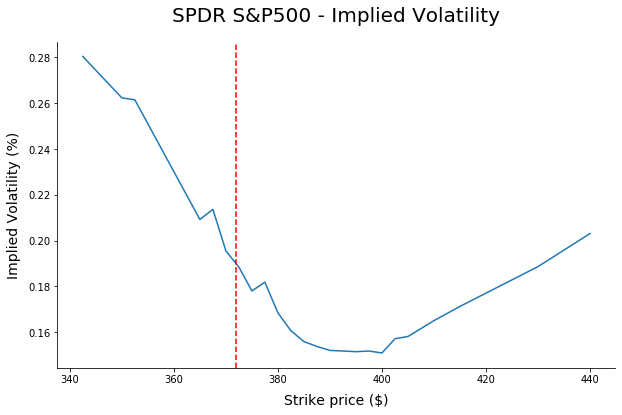

In [18]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(K.tolist(),imply_vol)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axvline(x=S, c='r', ls='--')

plt.title('SPDR S&P500 - Implied Volatility', fontdict=title_dict, pad=20)
plt.xlabel('Strike price ($)',fontdict=label_dict,labelpad=20)
plt.ylabel('Implied Volatility (%)',fontdict=label_dict, labelpad=10)

plt.show()

Finally, the assumed market volatility will be 0.1884% which corresponds to the strike price of $372.5. This implied volatility is an annualized measure based on the expectation of changes in one month. The standard deviation of the market returns can be estimated as follows:

In [23]:
print(f'The standard deviation on the market returns is {round(imply_vol[i]/np.sqrt(12)*100,2)}%')

The standard deviation on the market returns is 5.86%


This implies that if S&P500 follows a normal distribution there is a 68.2% probability that the price will move 5.86%, up or down, during the next month.

__Conclusion:__ 

Using the Black-Scholes model and the Monte Carlo simulation is posible to estimate the implied volatility of an option. An alternative optimization method to the Monte Carlo simulation is using the Newton's method, this could make the algortihm more efficient.The implied volatility calculated is a forward-looking tool that helps to understand market sentiments of potential movements in price during a specific period of time. Although the direction of the movement is unknown, the analyst can determine periods of high or low volatility and prepare the strategy accordingly.

__References:__
- Tim Worall (2008). The Black-Scholes Formula, FIN-40008 Financial Instruments http://www.timworrall.com/fin-40008/bscholes.pdf
- Tirthajyoti Sarkar (2020). Monte Carlo integration in Python. https://www.kdnuggets.com/2020/12/monte-carlo-integration-python.html
- volatility Smile https://quantra.quantinsti.com/glossary/Volatility-Smile 

__Disclaimer:__

The content of this notebook is intended to be used and must be used for informational purposes only. It is very important to do your own analysis before making any investment based on your own personal circumstances. You should take independent financial advice from a professional in connection with, or independently research and verify, any information that you find on this notebook and wish to rely upon, whether for the purposes of making an investment decision or otherwise.

Past performance is not a guarantee of future return, nor is it necessarily indicative of future performance. Keep in mind investing involves risk. The value of your investment will fluctuate over time and you may gain or lose money.